In [17]:
import os
import time
import pickle

import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy import ndimage as nd
from skimage import transform
from tqdm.notebook import tqdm

#import isx

In [2]:
def apply_butterworth(sig,cutoff,fs,filt_order,filt_type):
    #
    # applies zero-phase digital butterworth filter to data in sig
    # if sig is a matrix, data in its columns are filtered
    #
    # cutoff is filter's critical frequency in Hz, or n=2 tuple of freqs for bandpass filters
    # fs is sampling rate
    # filt_order is integer filter order
    # filt_type is 'lowpass','highpass', 'bandpass', or 'bandstop' 
    # 
    # returns filtered signal 
    #
    
    nyq = 0.5 * fs
    norm_cutoff =cutoff/nyq
    b,a = signal.butter(filt_order,norm_cutoff,btype=filt_type,analog=False)
    
    if sig.ndim > 1:
        filt_sig = signal.filtfilt(b,a,sig,axis=1)
    elif sig.ndim == 1:
        filt_sig = signal.filtfilt(b,a,sig)
    else:
        filt_sig = []
    
    return filt_sig

def median_filter_matrix(inmtx,winsize=3):
    #
    # median filters each column of matrix with kernal width = winsize
    #
    # returns filtered matrix
    #
    
    filtmtx = np.zeros_like(inmtx)
    
    for i in range(inmtx.shape[0]):
        filtmtx[i] = signal.medfilt(inmtx[i],winsize)
    return filtmtx

def otsu(x):
    # returns threshold estimated via Otsu's method
    # x needs to be 1-d list
    nbins = 500
    logx = np.log(x)
    
    minim = min(logx)
    maxim = max(logx)
    logx = (logx-minim)/(maxim-minim)
    
    xhist = np.histogram(logx,bins=nbins)
    xbins = xhist[1]
    xbins = xbins[1:]
    xcounts = xhist[0] / sum(xhist[0])

    maximum = 0
    thresh = 0
    
    for t in range(len(xcounts)):
        w0 = sum(xcounts[:t])
        w1 = sum(xcounts) - w0
        if w0 == 0 or w1 == 0:
            #print('continuing...')
            continue
        mu0 = sum(xbins[:t]*xcounts[:t]) / w0
        mu1 = sum(xbins[t:]*xcounts[t:]) / w1
        sigB = w0 * w1 * ((mu0 - mu1) * (mu0 - mu1))
        if sigB >= maximum:
            maximum = sigB
            thresh = xbins[t]
    
    th = thresh*(maxim-minim) + minim
    th = np.exp(th)
    #th = np.power(10,th)
    thresh = th

    return thresh


def register_signals(ref_time,in_dat,in_time):
    #
    # Direct alignment of signals that were sampled at diffrent rates
    # resamples in_dat to len(ref_time) by aligning timestamps in ref_time with timestamps in in_time
    # in_time is vector of timestamps for data in in_dat
    #
    # len(ref_time) < len(in_time)
    #
    #
    
    resamp_dat = np.zeros_like(ref_time)

    for t in range(len(ref_time)):
        dat = in_dat[bisect.bisect(in_time,ref_time[t])-1]
        resamp_dat[t] = dat
    return resamp_dat
    
def segment(x,thresh):
    # returns onsets & offset indices of impulses that exceed thresh in vector x
    xsub = x - thresh
    xdiff = (xsub[:-1]*xsub[1:]) < 0
    edges = np.where(xdiff == 1) # indices at onsets/offsets
    edges = list(edges[0])
    
    x[0:5] = 0
    
    if np.mean(np.diff(x[edges[0]-2:edges[0]+2])) < 0: # delete first impulse if offset
        print('first impulse is offset')
        edges.pop(0)
    if np.mean(np.diff(x[edges[-1]-2:edges[-1]+2])) > 0: # delete last impulse if onset
        print('last impulse is onset')
        edges.pop(-1)
    onsets = edges[0::2]
    offsets = edges[1::2]
    
    if len(onsets) > len(offsets):
        onsets.pop(-1)
    
    return [onsets,offsets]

def extractsegments(x,onsets,offsets,win):
    # returns list of slices from x[onsets[i]-win:offsets[i]+win]
    
    win = int(win)
    if onsets[0] - win < 1 or offsets[-1] > len(x):
        print('Edge Syllable')
        return []
    else:
        segs = [x[onsets[i]-win : offsets[i]+win] for i in range(len(onsets))]
        return segs
    
def filtersegments(segs,minlen,maxlen):
    # deletes elements of segs with maxlen < len() < minlen
    return [i for i in segs if len(i) > minlen and len(i) < maxlen]
    
def twoaxis(axname,lwidth=2):
    #
    # formats axes by setting axis thickness & ticks to lwidth and clearing top/right axes
    #
    #
    axname.spines['bottom'].set_linewidth(lwidth)
    axname.tick_params(width=lwidth)
    axname.spines['left'].set_linewidth(lwidth)
    axname.spines['top'].set_linewidth(0)
    axname.spines['right'].set_linewidth(0)
    
# functions for object detection:

def subtract_img_background(input_img):
    #
    # Uses pixel dilation to adaptively filter nonuniform background from objects in input_img
    #
    # input image is NxM  matrix of pixel intensities 
    #
    # returns filtered image.
    #
    # Adapted from skimage 'Filtering regional maxima'. Requires : 
    # import numpy as np
    # import matplotlib.pyplot as plt
    # from scipy.ndimage import gaussian_filter
    # from skimage.filters import threshold_otsu
    # #from skimage import img_as_float
    # from skimage.morphology import reconstruction
    #
    #
    img = img_as_float(input_img)
    img_g = gaussian_filter(img,1)

    h = threshold_otsu(img_g)

    seed = img_g - h
    mask = img_g

    dilated = reconstruction(seed,mask,method='dilation')

    return img_g-dilated

def norm_image(in_img):
    #
    # returns in_img normalized to [0-255]
    #
    #
    
    i_min = np.min(in_img)
    i_max = np.max(in_img)
    
    norm_img = 255 * ((in_img + abs(i_min) / i_max))
    
    return norm_img

def estimate_num_cells(in_img):
    #
    # Estimates number of gaussian-like blobs in in_img using laplacian of gaussians (LoG)
    #
    # 
    # in_img is NxM matrix of pixel intensities
    # in_img is probably maximum or other projection of motion corrected or df/f movie
    #
    # requires skimage.feature.blob_log()
    #
    # returns N x 3 matrix, N=num_blobs, out[0] = y coordinates, out[1] = x coordinates, out[2] = blob radius 
    #
    
    # log_params:
    min_sigma = 2
    max_sigma = 20
    num_sigma = int((max_sigma-min_sigma))
    threshold = 1
    overlap =0.1
    
    img_background_subtract = subtract_img_background(in_img)
    img_norm = norm_image(img_background_subtract)
    objs = blob_log(img_norm,min_sigma = min_sigma,max_sigma=max_sigma,num_sigma=num_sigma,threshold=threshold,overlap=overlap)
    
    return objs


In [3]:
def get_background_images(in_movie, seg_times, n_background_frames = 500, fps = 20):
    #
    # 
    #
    #
    #
    
    print('Background detection assuming {}fps video\n'.format(fps))
    
    rng = np.random.default_rng()
    
    vid = cv2.VideoCapture(in_movie)
    num_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    vid_size = [int(vid.get(4)), int(vid.get(3))]
    
    # convert segments to indices and add start/stop frames:
    seg_times = [int(i*fps) for i in seg_times]
    seg_times.append(num_frames)
    seg_times.insert(0, 0)
    seg_idx = [[i, j] for i,j in zip(seg_times[:-1], seg_times[1:]) ]
    
    out_list = []
    
    # build background image for each segment:
    for seg in tqdm(seg_idx):
        framevect = np.unique(rng.integers(seg[0], seg[1], int(n_background_frames * 2)))[:n_background_frames] # draw n_background_frames without replacement
        background_dat = np.zeros( (len(framevect), vid_size[0], vid_size[1]) ).astype('uint8')
        #vid = cv2.VideoCapture(vid_fn)
        #bidx = 0
        for bidx,i in enumerate(framevect):
            vid.set(1, i)
            theframe = vid.read()[1]
            grayscale = cv2.cvtColor(theframe,cv2.COLOR_BGR2GRAY).astype('uint8')
            #grayscale = (np.sum(theframe,axis=2)/3).astype('uint8')
            background_dat[bidx] = grayscale
            #bidx += 1        

        #background_frame = np.median(background_dat, axis=0)
        out_list.append(np.median(background_dat, axis=0))
        

    
    vid.release()
    return out_list

###################################################################################
###################################################################################

def movie_com(in_movie, background_movie, seg_times, filt_size = 10, ds_fact = 4, pthresh = 99, fps = 20):
    #
    #
    #

    vid = cv2.VideoCapture(in_movie)
    num_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_range = list(range(num_frames))

    # initialize output:
    com_vect = np.zeros((len(frame_range),2)).astype('int32')
    
    seg_times = [int(i*fps) for i in seg_times]
    seg_times.append(num_frames)
    seg_times.insert(0, 0)
    seg_idx = [[i, j] for i,j in zip(seg_times[:-1], seg_times[1:]) ]
    
    movie_epochs = [np.arange(i[0],i[1]) for i in seg_idx]
    print(np.shape(movie_epochs))

    for framei in tqdm(range(len(frame_range))):
        vid.set(1, framei)
        theframe = vid.read()[1]

        background_frame_ds = transform.downscale_local_mean(background_movie[np.argwhere([framei in i for i in movie_epochs])[0][0]], (ds_fact, ds_fact))
        grayscale = transform.downscale_local_mean( cv2.cvtColor(theframe,cv2.COLOR_BGR2GRAY).astype('uint8'), (ds_fact,ds_fact))

        bg_subtracted = grayscale - background_frame_ds
        bg_subtracted[bg_subtracted > np.percentile(bg_subtracted, 100-pthresh)] = 0
        bg_subtracted[bg_subtracted > 0] = 255

        center_of_mass = nd.center_of_mass(nd.maximum_filter(bg_subtracted, int(filt_size / ds_fact )))
        
        if sum(np.isnan(center_of_mass)):
            com_vect[framei] = com_vect[framei -1]
        else:
            com_vect[framei] = [i for i in center_of_mass]

    vid.release()
    return com_vect

###################################################################################
###################################################################################


    


## Gather data from spreadsheet

In [4]:
log_fn = '/home/mmiller/Downloads/Experimental Log - Sheet1.csv'
log_df = pd.read_csv(log_fn)
log_df.head()

,date,subject_ID,genotype,virus,expression_time,brain_region,condition,data_dir_ca,isxd_data_basename,data_dir_behavior,behav_data_basename,Focus,Gain,LED,Comments,num_cells
0,20200302,OM025,PV,CaM6m_FLEXeNpHR,8 weeks,mPFC,enphr_stim,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-03-02-12-04-44_video,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20200302,OM025,PV,CaM6m_FLEXeNpHR,8 weeks,mPFC,enphr_stim,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-03-02-12-26-53_video,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20200302,OM025,PV,CaM6m_FLEXeNpHR,8 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-03-02-14-25-34_video,NaN,Behavior_2020-03-02-14-25-34_video,NaN,NaN,NaN,NaN,NaN
3,20200401,OM037,FMR1CTRL,CaM6m,5 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-04-01-14-34-36_video,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-01-14-34-36_video,660.0,6.8,0.2,num cells estimate is low due to blurry projec...,29.0
4,20200401,OM047,FMR1CTRL,CaM6m,5 weeks,mPFC,linear_social,\\science-1\data\OM\Astellas\inscopix_imaging\...,2020-04-01-15-19-03_video,\\science-1\data\OM\Astellas\social_linear_beh...,behavior_2020-04-01-15-19-03_video,610.0,6.4,0.4,lens insertion only 5 days ago,74.0


In [5]:
behavior_dir = '/home/mmiller/Documents/data/astellas/fmr1ko_linear_social/April2020_FMR1_LinearSocial/'
com_list = [i for i in os.listdir(behavior_dir) if os.path.splitext(i)[1] == '.csv']
#print(com_list)


In [6]:
print(com_list)

['behavior_2020-04-15-14-40-41_video_COM.csv', 'behavior_2020-04-01-14-34-36_video_COM.csv', 'behavior_2020-04-02-11-16-06_video_COM.csv', 'behavior_2020-04-01-16-41-16_video_COM.csv', 'behavior_2020-04-01-15-19-03_video_COM.csv', 'behavior_2020-04-02-10-32-52_video_COM.csv', 'behavior_2020-04-02-09-54-15_video_COM.csv', 'behavior_2020-04-01-15-59-43_video_COM.csv', 'behavior_2020-04-02-11-57-37_video_COM.csv', 'behavior_2020-04-15-13-18-00_video_COM.csv', 'behavior_2020-04-08-11-37-35_video_COM.csv', 'behavior_2020-04-08-12-15-55_video_COM.csv', 'behavior_2020-04-08-13-22-44_video_COM.csv', 'behavior_2020-04-08-14-02-40_video_COM.csv', 'behavior_2020-04-08-14-41-15_video_COM.csv', 'behavior_2020-04-08-15-21-57_video_COM.csv', 'behavior_2020-04-08-16-29-32_video_COM.csv', 'behavior_2020-04-15-14-03-28_video_COM.csv', 'behavior_2020-04-15-12-41-38_video_COM.csv', 'behavior_2020-04-15-15-33-42_video_COM.csv', 'behavior_2020-04-15-16-09-03_video_COM.csv', 'behavior_2020-04-15-16-47-50_vid

In [7]:
print(log_df.subject_ID.values)

['OM025' 'OM025' 'OM025' 'OM037' 'OM047' 'OM045' 'OM038' 'OM035' 'OM040'
 'OM042' 'OM051' 'OM037' 'OM047' 'OM045' 'OM038' 'OM051' 'OM042' 'OM040'
 'OM035' 'OM045' 'OM038' 'OM037' 'OM047' 'OM051' 'OM042' 'OM040' 'OM035'
 'OM045' 'OM045' 'OM038' 'OM038' 'OM047' 'OM047' 'OM035' 'OM035' 'OM051'
 'OM051' 'OM042' 'OM042' 'OM040' 'OM040' 'OM035' 'OM035' 'OM045' 'OM045'
 'OM038' 'OM038' 'OM047' 'OM047' 'OM035' 'OM035' 'OM051' 'OM051' 'OM042'
 'OM042' 'OM040' 'OM040' 'OM045' 'OM038' 'OM047' 'OM042' 'OM035' 'OM051'
 'OM040' 'Astellas_DCMCtx_1' 'Astellas_DCMCtx_2' 'Astellas_DCMCtx_3'
 'Astellas_DCMCtx_3' 'Astellas_DCMCtx_4' 'Astellas_DCMCtx_4'
 'Astellas_DCMCtx_1' 'Astellas_DCMCtx_3' 'Astellas_DCMCtx_3'
 'Astellas_DCMCtx_2' 'Astellas_DCMCtx_4' 'Astellas_DCMCtx_4'
 'cage1_mouse2' 'cage3_mouse3' 'cage1_mouse7' 'cage3_mouse8'
 'cage1_mouse11' 'cage3_mouse10' 'cage3_mouse10' 'cage1_mouse8'
 'cage1_mouse8' 'cage3_mouse9' 'cage3_mouse9' 'cage3_mouse2'
 'cage3_mouse2' 'cage5_mouse2' 'cage5_mouse2' 'cage

In [8]:
log_df.condition.unique()

array(['enphr_stim', 'linear_social', nan,
       'FOV SHIFTED - one cell visible - did not run', 'homecage_saline',
       'linear_social_saline', 'homecage_5mgkg_rBaclofen',
       'linear_social_5mgkg_rBaclofen', 'homecage_1.5mgkg_rBaclofen',
       'linear_social_1.5mgkg_rBaclofen', 'free_social', 'OFT',
       'OFT_Stim', 'OFT_ket_at_10'], dtype=object)

In [9]:
vid_df = log_df[['subject_ID', 'genotype','data_dir_behavior','condition', 'behav_data_basename']].loc[
    (~log_df.behav_data_basename.isna()) & (log_df.condition.isin(['linear_social_saline', 'linear_social_1.5mgkg_rBaclofen']))].copy()

In [10]:
vid_df

,subject_ID,genotype,data_dir_behavior,condition,behav_data_basename
28,OM045,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_saline,behavior_2020-04-22-13-31-53_video
30,OM038,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_saline,behavior_2020-04-22-14-39-05_video
32,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_saline,behavior_2020-04-22-15-50-49_video
36,OM051,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-23-13-31-16_video
38,OM042,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-23-14-52-01_video
40,OM040,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-23-16-09-56_video
42,OM035,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-24-10-53-29_video
44,OM045,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-29-12-19-50_video
46,OM038,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-29-13-39-59_video
48,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-29-14-54-29_video


In [13]:
subj_ids = vid_df.subject_ID.unique()
print(vid_df.behav_data_basename.loc[vid_df.subject_ID==subj_ids[0]].values[0]+'_COM.mp4')
print(subj_ids)

behavior_2020-04-22-13-31-53_video_COM.mp4
['OM045' 'OM038' 'OM047' 'OM051' 'OM042' 'OM040' 'OM035']


In [14]:
# examine behavior zones on example video:
ds_fact = 1
x_threshs = [88,218]
subj_id = 0
framei = int(60*20*7)


OM045


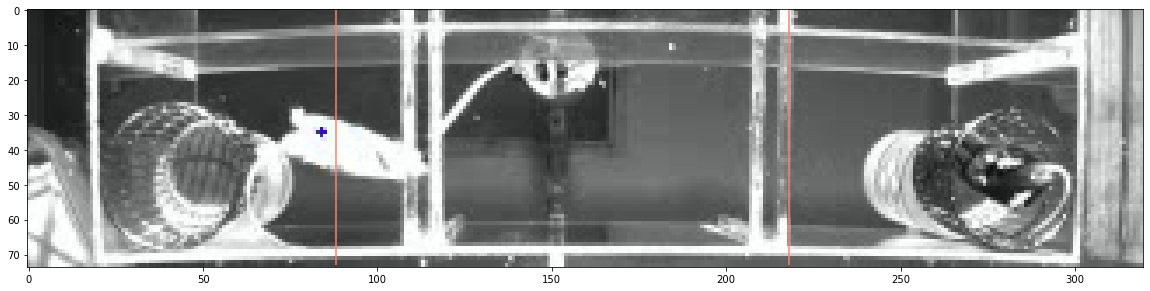

In [15]:
# examine behavior zones on example video:

#vid_fn = '/home/mmiller/Documents/data/astellas/fmr1ko_linear_social/April2020_FMR1_LinearSocial/behavior_2020-04-01-14-34-36_video_COM.mp4'
vid_fn = behavior_dir + vid_df.behav_data_basename.loc[vid_df.subject_ID==subj_ids[subj_id]].values[0]+'_COM.mp4'
print(subj_ids[subj_id])

vid = cv2.VideoCapture(vid_fn)
frame_height = vid.get(cv2.CAP_PROP_FRAME_HEIGHT)
vid.set(1, framei)
theframe = vid.read()[1]
#grayscale = transform.downscale_local_mean( cv2.cvtColor(theframe,cv2.COLOR_BGR2GRAY).astype('uint8'), (ds_fact,ds_fact)).astype('uint8')
vid.release()

f,ax = plt.subplots(1,1,figsize=(20,5))
ax.imshow(theframe,cmap='gray')
ax.vlines(x_threshs, ymin=0, ymax=frame_height-1, color='salmon')
plt.show()

In [34]:
#test_side=dict()
test_side[subj_ids[subj_id]] = 'l'
print(test_side)

{'OM047': 'l', 'OM045': 'r', 'OM038': 'l', 'OM051': 'r', 'OM042': 'l', 'OM040': 'r', 'OM035': 'l'}


## Load existing dict of target sides if available:

In [18]:
test_side_fn = 'target_sides_baclofen.pkl'
test_side = pickle.load(open(test_side_fn, 'rb'))

In [19]:
test_side

{'linear_social_saline': {'OM045': 'r',
  'OM038': 'l',
  'OM047': 'r',
  'OM051': 'r',
  'OM042': 'l',
  'OM040': 'r',
  'OM035': 'r'},
 'linear_social_1.5mgkg_rBaclofen': {'OM045': 'l',
  'OM038': 'l',
  'OM047': 'r',
  'OM051': 'r',
  'OM042': 'l',
  'OM040': 'r',
  'OM035': 'l'}}

In [20]:
subj_ids = vid_df.subject_ID.values
print(subj_ids)

['OM045' 'OM038' 'OM047' 'OM051' 'OM042' 'OM040' 'OM035' 'OM045' 'OM038'
 'OM047' 'OM035' 'OM051' 'OM042' 'OM040']


In [21]:
vid_df['novel_side'] = ''

In [22]:
for i in test_side:
    print(i)
    vid_df['novel_side'] = vid_df['subject_ID'].map(test_side[i])

#vid_df['novel_side'] = vid_df['subject_ID'].map(test_side)

linear_social_saline
linear_social_1.5mgkg_rBaclofen


In [23]:
vid_df

,subject_ID,genotype,data_dir_behavior,condition,behav_data_basename,novel_side
28,OM045,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_saline,behavior_2020-04-22-13-31-53_video,l
30,OM038,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_saline,behavior_2020-04-22-14-39-05_video,l
32,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_saline,behavior_2020-04-22-15-50-49_video,r
36,OM051,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-23-13-31-16_video,r
38,OM042,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-23-14-52-01_video,l
40,OM040,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-23-16-09-56_video,r
42,OM035,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-24-10-53-29_video,l
44,OM045,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-29-12-19-50_video,l
46,OM038,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-29-13-39-59_video,l
48,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-29-14-54-29_video,r


In [56]:
the_cond = 'linear_social_1.5mgkg_rBaclofen'

## count l/r occupancy for each epoch for each subject:
epoch_times = [0, int(5*60*20), int(15*60*20)]
buffer_len = 30*20

occupancy_dict = dict()


for subj in np.unique(subj_ids):
    print(subj)
    com_fn = behavior_dir + vid_df.behav_data_basename.loc[(vid_df.subject_ID==subj) & (vid_df.condition == the_cond)].values[0]+'_COM.csv'
    #print(com_fn)
    the_com = np.loadtxt(com_fn, delimiter=',')
    
    the_epochs = list(np.copy(epoch_times))
    the_epochs.append(len(the_com))
    epoch_segs = [[i+buffer_len, j-buffer_len] for i,j in zip(the_epochs[0:-1], the_epochs[1:])]
    
    occupancy_times = []
    for seg_i, seg in enumerate(epoch_segs):
        print(seg)
        left_time = int(sum(the_com[seg[0]:seg[1], 1] < x_threshs[0]))
        right_time = int(sum(the_com[seg[0]:seg[1], 1] > x_threshs[1]))
        #out_times[subj_i, seg_i, :] = [left_time, right_time]
        
        if seg_i == 0:
            occupancy_times.append([left_time, right_time])
            print('Habituation scores',left_time,right_time)        
        
        if seg_i == 1: 
            if vid_df.novel_side.loc[(vid_df.subject_ID == subj) & (vid_df.condition == the_cond)].values == 'l': # correctly order times to map social target position to the right ([object, pref])
                occupancy_times.append([right_time, left_time])
                print('remap scores:', right_time,left_time)
            else:
                occupancy_times.append([left_time, right_time])      
                print('unmapped scores',left_time,right_time)
        if seg_i == 2: 
            if vid_df.novel_side.loc[(vid_df.subject_ID == subj) & (vid_df.condition == the_cond)].values == 'l': # correctly order times to map novel target position to the right ([pref, novel])
                occupancy_times.append([left_time, right_time])
                print('unmapped scores:', left_time,right_time)
            else:
                occupancy_times.append([right_time, left_time])      
                print('remapped scores',right_time, left_time)

    occupancy_dict[subj] = occupancy_times
    print('\n')
    
print(occupancy_dict)

OM035
[600, 5400]
Habituation scores 912 2324
[6600, 17400]
remap scores: 610 8578
[18600, 29987]
unmapped scores: 5919 3730


OM038
[600, 5400]
Habituation scores 0 4800
[6600, 17400]
remap scores: 8006 413
[18600, 30234]
unmapped scores: 3996 6596


OM040
[600, 5400]
Habituation scores 0 4800
[6600, 17400]
unmapped scores 7151 1065
[18600, 31171]
remapped scores 2776 7300


OM042
[600, 5400]
Habituation scores 2380 2153
[6600, 17400]
remap scores: 9667 937
[18600, 30880]
unmapped scores: 4673 6894


OM045
[600, 5400]
Habituation scores 1799 1834
[6600, 17400]
remap scores: 6996 2422
[18600, 30841]
unmapped scores: 4066 7506


OM047
[600, 5400]
Habituation scores 1257 2493
[6600, 17400]
unmapped scores 3296 6768
[18600, 30156]
remapped scores 8685 2156


OM051
[600, 5400]
Habituation scores 3399 129
[6600, 17400]
unmapped scores 8971 389
[18600, 30668]
remapped scores 3156 7349


{'OM035': [[912, 2324], [610, 8578], [5919, 3730]], 'OM038': [[0, 4800], [8006, 413], [3996, 6596]], 'OM04

In [57]:
vid_df

,subject_ID,genotype,data_dir_behavior,condition,behav_data_basename,novel_side,habituation_counts,pref_counts,novel_counts
28,OM045,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_saline,behavior_2020-04-22-13-31-53_video,l,"[1726, 1284]","[3995, 4892]","[2738, 6743]"
30,OM038,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_saline,behavior_2020-04-22-14-39-05_video,l,"[2060, 1029]","[2613, 5835]","[4679, 5044]"
32,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_saline,behavior_2020-04-22-15-50-49_video,r,"[1242, 1997]","[3802, 5477]","[3807, 5322]"
36,OM051,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-23-13-31-16_video,r,"[3399, 129]","[8971, 389]","[3156, 7349]"
38,OM042,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-23-14-52-01_video,l,"[2380, 2153]","[9667, 937]","[4673, 6894]"
40,OM040,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-23-16-09-56_video,r,"[0, 4800]","[267, 8351]","[2776, 7314]"
42,OM035,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-24-10-53-29_video,l,"[912, 2324]","[610, 8578]","[5919, 3730]"
44,OM045,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-29-12-19-50_video,l,"[1799, 1834]","[6996, 2422]","[4066, 7506]"
46,OM038,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-29-13-39-59_video,l,"[0, 4800]","[8006, 413]","[3996, 6596]"
48,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-29-14-54-29_video,r,"[1257, 2493]","[3296, 6768]","[8685, 2156]"


In [58]:
occupancy_dict

{'OM035': [[912, 2324], [610, 8578], [5919, 3730]],
 'OM038': [[0, 4800], [8006, 413], [3996, 6596]],
 'OM040': [[0, 4800], [7151, 1065], [2776, 7300]],
 'OM042': [[2380, 2153], [9667, 937], [4673, 6894]],
 'OM045': [[1799, 1834], [6996, 2422], [4066, 7506]],
 'OM047': [[1257, 2493], [3296, 6768], [8685, 2156]],
 'OM051': [[3399, 129], [8971, 389], [3156, 7349]]}

In [59]:
## populate df with occupancy scores
habituation_times = {i:j[0] for i,j in zip(occupancy_dict.keys(), occupancy_dict.values())}
print(habituation_times)


pref_times = {i:occupancy_dict[i][1] for i in occupancy_dict}
print(pref_times)

novel_times = {i:occupancy_dict[i][2] for i in occupancy_dict}
print(novel_times)



{'OM035': [912, 2324], 'OM038': [0, 4800], 'OM040': [0, 4800], 'OM042': [2380, 2153], 'OM045': [1799, 1834], 'OM047': [1257, 2493], 'OM051': [3399, 129]}
{'OM035': [610, 8578], 'OM038': [8006, 413], 'OM040': [7151, 1065], 'OM042': [9667, 937], 'OM045': [6996, 2422], 'OM047': [3296, 6768], 'OM051': [8971, 389]}
{'OM035': [5919, 3730], 'OM038': [3996, 6596], 'OM040': [2776, 7300], 'OM042': [4673, 6894], 'OM045': [4066, 7506], 'OM047': [8685, 2156], 'OM051': [3156, 7349]}


In [29]:
vid_df['habituation_counts'] = ''
vid_df['pref_counts'] = ''
vid_df['novel_counts'] = ''



In [60]:
vid_df['habituation_counts'].loc[(vid_df.condition == the_cond)] = vid_df['subject_ID'].map(habituation_times)
vid_df['pref_counts'].loc[(vid_df.condition == the_cond)] = vid_df['subject_ID'].map(pref_times)
vid_df['novel_counts'].loc[(vid_df.condition == the_cond)] = vid_df['subject_ID'].map(novel_times)

In [61]:
vid_df

,subject_ID,genotype,data_dir_behavior,condition,behav_data_basename,novel_side,habituation_counts,pref_counts,novel_counts
28,OM045,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_saline,behavior_2020-04-22-13-31-53_video,l,"[1726, 1284]","[3995, 4892]","[2738, 6743]"
30,OM038,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_saline,behavior_2020-04-22-14-39-05_video,l,"[2060, 1029]","[2613, 5835]","[4679, 5044]"
32,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_saline,behavior_2020-04-22-15-50-49_video,r,"[1242, 1997]","[3802, 5477]","[3807, 5322]"
36,OM051,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-23-13-31-16_video,r,"[3399, 129]","[8971, 389]","[3156, 7349]"
38,OM042,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-23-14-52-01_video,l,"[2380, 2153]","[9667, 937]","[4673, 6894]"
40,OM040,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-23-16-09-56_video,r,"[0, 4800]","[7151, 1065]","[2776, 7300]"
42,OM035,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-24-10-53-29_video,l,"[912, 2324]","[610, 8578]","[5919, 3730]"
44,OM045,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-29-12-19-50_video,l,"[1799, 1834]","[6996, 2422]","[4066, 7506]"
46,OM038,FMR1KO,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-29-13-39-59_video,l,"[0, 4800]","[8006, 413]","[3996, 6596]"
48,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-29-14-54-29_video,r,"[1257, 2493]","[3296, 6768]","[8685, 2156]"


In [64]:
vid_df.loc[(vid_df.condition == the_cond) & (vid_df.genotype == 'FMR1CTRL')]

,subject_ID,genotype,data_dir_behavior,condition,behav_data_basename,novel_side,habituation_counts,pref_counts,novel_counts
36,OM051,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-23-13-31-16_video,r,"[3399, 129]","[8971, 389]","[3156, 7349]"
42,OM035,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-24-10-53-29_video,l,"[912, 2324]","[610, 8578]","[5919, 3730]"
48,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_1.5mgkg_rBaclofen,behavior_2020-04-29-14-54-29_video,r,"[1257, 2493]","[3296, 6768]","[8685, 2156]"


In [66]:
vid_df.loc[(vid_df.condition == 'linear_social_saline') & (vid_df.genotype == 'FMR1CTRL')]

,subject_ID,genotype,data_dir_behavior,condition,behav_data_basename,novel_side,habituation_counts,pref_counts,novel_counts
32,OM047,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_saline,behavior_2020-04-22-15-50-49_video,r,"[1242, 1997]","[3802, 5477]","[3807, 5322]"
50,OM035,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_saline,behavior_2020-04-30-11-45-56_video,l,"[1266, 1534]","[6316, 3192]","[6812, 3680]"
52,OM051,FMR1CTRL,\\science-1\data\OM\Astellas\social_linear_beh...,linear_social_saline,behavior_2020-04-30-13-13-50_video,r,"[2435, 834]","[3901, 5519]","[7757, 2192]"


In [ ]:
print(vid_df.genotype.unique())

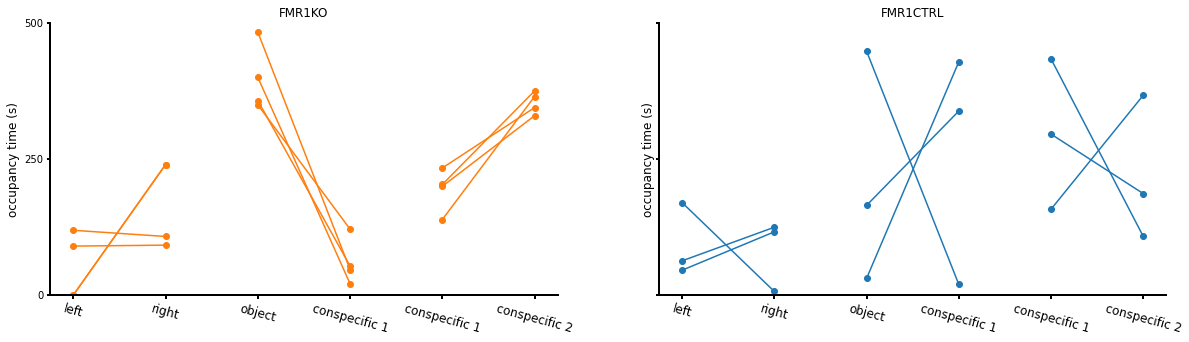

In [63]:
the_cond = 'linear_social_1.5mgkg_rBaclofen'

## plot / test occupancy:

gtypes = vid_df.genotype.unique()
cmap = plt.get_cmap('tab10')
#cdict = dict(zip(gtypes, [cmap(i) for i in np.linspace(0, 1 , len(gtypes))]))
cdict = dict(zip(gtypes, [cmap(i) for i in range(len(gtypes))][::-1]))

f,ax = plt.subplots(1, 2, figsize = (20,5), sharey=True)

for the_gtype,a in zip(gtypes,ax):
    the_subjs = vid_df.subject_ID.loc[(vid_df.genotype == the_gtype) & (vid_df.condition == the_cond)]

    for i in vid_df.habituation_counts.loc[(vid_df.subject_ID.isin(the_subjs)) & (vid_df.condition == the_cond) ]:
        a.plot([1, 1.1], [j/20 for j in i], 'o-', color = cdict[the_gtype])
    for i in vid_df.pref_counts.loc[(vid_df.subject_ID.isin(the_subjs)) & (vid_df.condition == the_cond)]:
        a.plot([1.2, 1.3], [j/20 for j in i], 'o-', color = cdict[the_gtype])
    for i in vid_df.novel_counts.loc[(vid_df.subject_ID.isin(the_subjs)) & (vid_df.condition == the_cond)]:
        a.plot([1.4, 1.5], [j/20 for j in i], 'o-', color = cdict[the_gtype])
        

for a, gtype in zip(ax, gtypes):
    a.set_title(gtype)
    a.set_xticks([1, 1.1, 1.2, 1.3, 1.4, 1.5])
    a.set_xticklabels(['left', 'right', 'object', 'conspecific 1', 'conspecific 1', 'conspecific 2'], rotation = 345, fontsize=12)
    a.set_ylim(0,500)
    a.set_yticks([0,250,500])
    a.set_ylabel('occupancy time (s)', fontsize=12)
    twoaxis(a)
plt.show()


